<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LLaVa/Inference_with_LLaVa_for_multimodal_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls

drive/  sample_data/


In [3]:
%cd drive/MyDrive/SketchToReality/

/content/drive/MyDrive/SketchToReality


In [4]:
%ls

Data/  Dataset/  data_viusalization_colab.ipynb  utils/


# Inference with LLaVa, a multimodal LLM

LLaVa is an exciting new multimodal LLM which extends large language models like [LLaMa](https://huggingface.co/docs/transformers/model_doc/llama) with visual inputs.

For multimodal LLMs, one typically takes a pre-trained/fine-tuned LLM and additionally conditions it on image features. In case of LLaVa, the image features come from a pre-trained [CLIP](https://huggingface.co/docs/transformers/model_doc/clip)'s vision encoder. To match the dimension of the image features with those of the text features, one applies a projection module, which could be a simple linear projection (like the original LLaVa), or more sophisticated like a two-layer MLP (used in LLaVa 1.5).

One then trains the model to predict the next text token, given image features and text tokens.

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

* Transformers docs: https://huggingface.co/docs/transformers/main/en/model_doc/llava.
* Original LLaVa paper: https://arxiv.org/abs/2304.08485
* LLaVa 1.5 paper: https://arxiv.org/pdf/2310.03744.pdf
* [notebook](https://colab.research.google.com/drive/1qsl6cd2c8gGtEW1xV5io7S8NHh-Cp1TV?usp=sharing#scrollTo=6Bx8iu9jOssW) which inspired me to create this notebook.

## Set-up environment

Let's start by installing the necessary libraries. Here we install Accelerate and Bitsandbytes in order to load the model in Google Colab. This enables [4-bit inference](https://huggingface.co/blog/4bit-transformers-bitsandbytes) with clever quantization techniques, shrinking the size of the model considerably, while maintaining performance of the original size.

In [5]:
!pip install --upgrade -q accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.6 MB/s eta 0:00:00


We also update the Transformers version of Google Colab to use the main branch, as the model is brand new at the time of writing.

In [6]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-xjn3yeq7
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-xjn3yeq7
  Resolved https://github.com/huggingface/transformers.git to commit 7d312ad2e9473cd3a0ea3e9b206b8ed3c147e9be
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.38.0.dev0-py3-none-any.whl size=8507143 sha256=2e385c6e28417ad6c385cb0a745509d5c6b551584d4c453973600ff0216a7749
  Stored in directory: /tmp/pip-ephem-wheel-cache-fnl9z_aj/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


## Load model and processor

Next, we load a model and corresponding processor from the hub. We specify device_map="auto" in order to automatically place the model on the available GPUs/CPUs (see [this guide](https://huggingface.co/docs/accelerate/usage_guides/big_modeling) for details).

Regarding [quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes), refer to the blog post for all details.

In [7]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)


model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Prepare image and text for the model

In [30]:
from PIL import Image
import os
import numpy as np
import glob

sketch_path = './Data/data/sketch/tx_000000000000/*/*'
list_all_files = []
for file in glob.glob(sketch_path, recursive=True):
    list_all_files.append(file)

Label: songbird


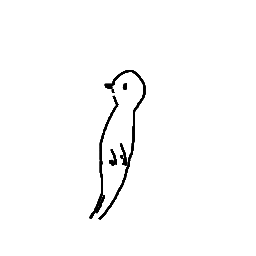

In [31]:
random_sketch_idx = np.random.randint(0, len(list_all_files))
random_sketch_path = list_all_files[random_sketch_idx]
label = random_sketch_path.split(sep='/')[-2]
RandomSketch = Image.open(random_sketch_path)
print(f'Label: {label}')
display(RandomSketch)

In the prompt, you can refer to images using the special \<image> token. To indicate which text comes from a human vs. the model, one uses USER and ASSISTANT respectively. The format looks as follows:

```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In other words, you always need to end your prompt with `ASSISTANT:`. Here we will perform batched generation (i.e generating on several prompts).

In [32]:
prompts = [
            "USER: <image>\nWhat is drawn in this art sketch?\nASSISTANT:",
            "USER: <image>\nIs there a particular style effect in this art sketch ?\nASSISTANT:"
]

# Input as many prompts as images (does not automatically scale)
inputs = processor(prompts, images=[RandomSketch, RandomSketch], padding=True, return_tensors="pt").to("cuda")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([2, 24])
attention_mask torch.Size([2, 24])
pixel_values torch.Size([2, 3, 336, 336])


## Autoregressively generate completion

Finally, we simply let the model predict the next tokens given the images + prompt. Of course one can adjust all the [generation parameters](https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/text_generation#transformers.GenerationMixin.generate). By default, greedy decoding is used.

In [34]:
output = model.generate(**inputs, max_new_tokens=100)
generated_text = processor.batch_decode(output, skip_special_tokens=True) # Greedy decoding
for text in generated_text:
  print(text.split("ASSISTANT:")[-1])

 In this art sketch, a bird is drawn.
 Yes, there is a particular style effect in this art sketch. The bird is depicted as a silhouette, which means that its shape and form are emphasized, while the background is left blank or white. This creates a striking contrast between the bird and its surroundings, making the bird the focal point of the image. The silhouette effect adds a sense of depth and dimension to the artwork, giving it a more dramatic and visually appealing appearance.


## Pipeline API

Alternatively, you can leverage the [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) API which abstracts all of the logic above away for the user. We also provide the quantization config to make sure we leverage 4-bit inference.

In [ ]:
from transformers import pipeline

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
max_new_tokens = 200
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"

outputs = pipe(image1, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

In [ ]:
print(outputs[0]["generated_text"])

USER:  
What are the things I should be cautious about when I visit this place?
ASSISTANT: When visiting this place, which is a pier or dock extending over a body of water, there are a few things to be cautious about. First, be aware of the weather conditions, as sudden changes in weather can make the pier unsafe to walk on. Second, be mindful of the water depth and any potential hazards, such as submerged rocks or debris, that could cause accidents or injuries. Additionally, be cautious of the presence of wildlife, such as birds or fish, and avoid disturbing their natural habitats. Lastly, be aware of any local regulations or guidelines for the use of the pier, as some areas may be restricted or prohibited for certain activities.


In [ ]:
# Transform batch of image of our dataset to list to feed to Llava

def batch_toPILlist(batch, dataset, show_batch = True): # batch is a list of tensors
    topil = transforms.ToPILImage()
    classes = dataset.classes
    PIL_list = []
    labels = []
    for i in range(len(batch[0])):
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        PILimage = topil(image)
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx] # In the DataLoader class
        PIL_list.append(PILimage)
        labels.append(label)

    if show_batch:
        visualize_batch(batch, classes, "")
    return PIL_list, labels